In [50]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import time
import scipy
import cartopy
import xarray as xr
import argopy 

In [ ]:
# Define region and load data into csv file
BOX=[87, 92, 15, 20, 0, 2000, '2015-10-01', '2024-09-30']# Bay of Bengal
ArgoSet = argopy.DataFetcher().region(BOX) 
df_raw = ArgoSet.data.argo.point2profile().to_dataframe()

# Remove rows with NaN values
df = df_raw.dropna(subset=['TEMP', 'PRES', 'PSAL'])

# Keep only rows where PSAL_QC, TEMP_QC, and PRES_QC are all equal to 1
df = df[(df['PSAL_QC'] == 1) & (df['TEMP_QC'] == 1) & (df['PRES_QC'] == 1)]

# df.to_csv('2015-2024-small-area.csv')

In [51]:
def load_csv():
    # Load the data from the CSV file
    data = pd.read_csv('2015-2024-small-area.csv')
    return data
all_data = load_csv()

# Get PLATFORM_NUMBER counts in decreasing order
platform_counts = all_data['PLATFORM_NUMBER'].value_counts()
print(platform_counts.head())# based on this, we pick the most frequently occurring float, here number 5904302

def filter_one_float(data):
    # Filter data for one specific float (e.g., PLATFORM_NUMBER 2902766)
    float_data = data[data['PLATFORM_NUMBER'] == 5904302]
    return float_data

# data = filter_one_float(all_data) #work with one float
data=all_data #work with all floats

print(data['TIME'].min())
print(data['TIME'].max())

PLATFORM_NUMBER
5904302    78260
2902189    64260
2902230    30867
2902234    26847
2902233    23541
Name: count, dtype: int64
2015-10-01 18:22:00
2024-09-04 11:41:24


In [55]:
# Define the pressure bins and labels
# Create pressure bins from 0 to max pressure
max_pressure = data['PRES'].max()
print('Max pressure over the selected period is '+str(max_pressure)+' dbar')
pressure_bins = np.concatenate((np.arange(0, 10, 2),np.arange(10, 100 , 10), np.arange(100, max_pressure + 25, 25)))
data['PRES_BIN'] = pd.cut(data['PRES'], bins=pressure_bins, labels=pressure_bins[:-1])

Max pressure over the selected period is 2000.0 dbar


In [56]:

# Convert 'TIME' to datetime if it's not already
data['TIME'] = pd.to_datetime(data['TIME'])

# Set 'TIME' as the index for resampling
data.set_index('TIME', inplace=True)

# Calculate weekly or monthly averages for each pressure bin
# Groupy by pressure bin and resample in time (week or month time step), then average temperature and salinity in each group. For monthly average : resample('M')
resampled_data = data.groupby('PRES_BIN', observed=True).resample('M').agg(
    avg_temp=('TEMP', 'mean'),
    avg_salinity=('PSAL', 'mean')
)
resampled_data.reset_index(inplace=True)

# Reset index to make it easier to save or work with for plotting
# resampled_data.reset_index(inplace=True)
print(resampled_data)

     PRES_BIN       TIME   avg_temp  avg_salinity
0         0.0 2016-03-31  28.496273     32.450020
1         0.0 2016-04-30  29.166333     32.590342
2         0.0 2016-05-31        NaN           NaN
3         0.0 2016-06-30  30.009222     33.499699
4         0.0 2016-07-31  29.420500     33.008641
...       ...        ...        ...           ...
9707   1975.0 2024-05-31   2.797141     34.779204
9708   1975.0 2024-06-30   2.951311     34.786034
9709   1975.0 2024-07-31   3.054333     34.791444
9710   1975.0 2024-08-31   3.041000     34.791500
9711   1975.0 2024-09-30   2.841000     34.783500

[9712 rows x 4 columns]


/var/folders/2w/tdn42d6s2lx6l_8md1rzw46r0000gn/T/ipykernel_3570/1042294514.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_data = data.groupby('PRES_BIN', observed=True).resample('M').agg(


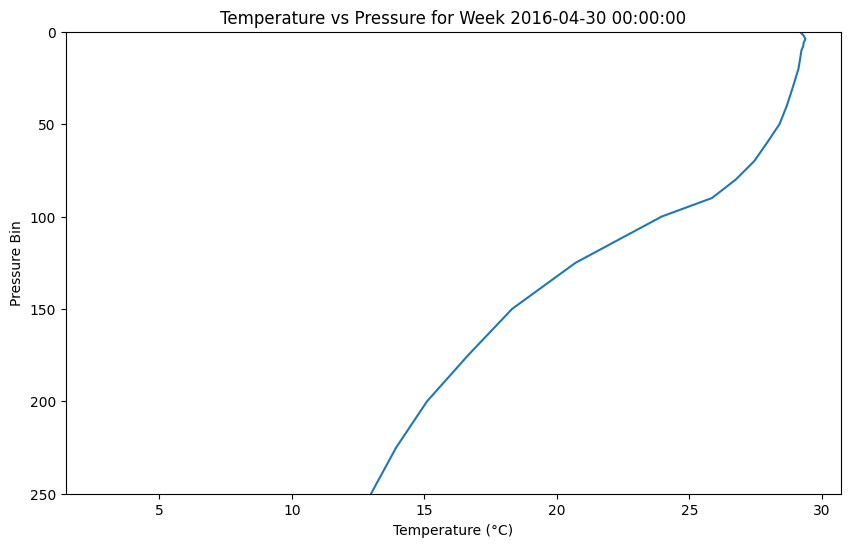

In [ ]:
# Plot averaged temperature for one month
t0 = '2016-04-30'
res_data=resampled_data[resampled_data['TIME']==t0]

plt.figure(figsize=(10, 6))
plt.plot(res_data['avg_temp'], res_data['PRES_BIN'])

# Step 4: Customizing the plot
plt.gca().invert_yaxis()  # Invert the y-axis so the surface is at the top
plt.xlabel('Temperature (°C)')
plt.ylabel('Pressure Bin')
plt.title(f'Temperature vs Pressure for Week {res_data["TIME"].iloc[0]}')
plt.ylim(250,0)
# Display the plot
plt.show()

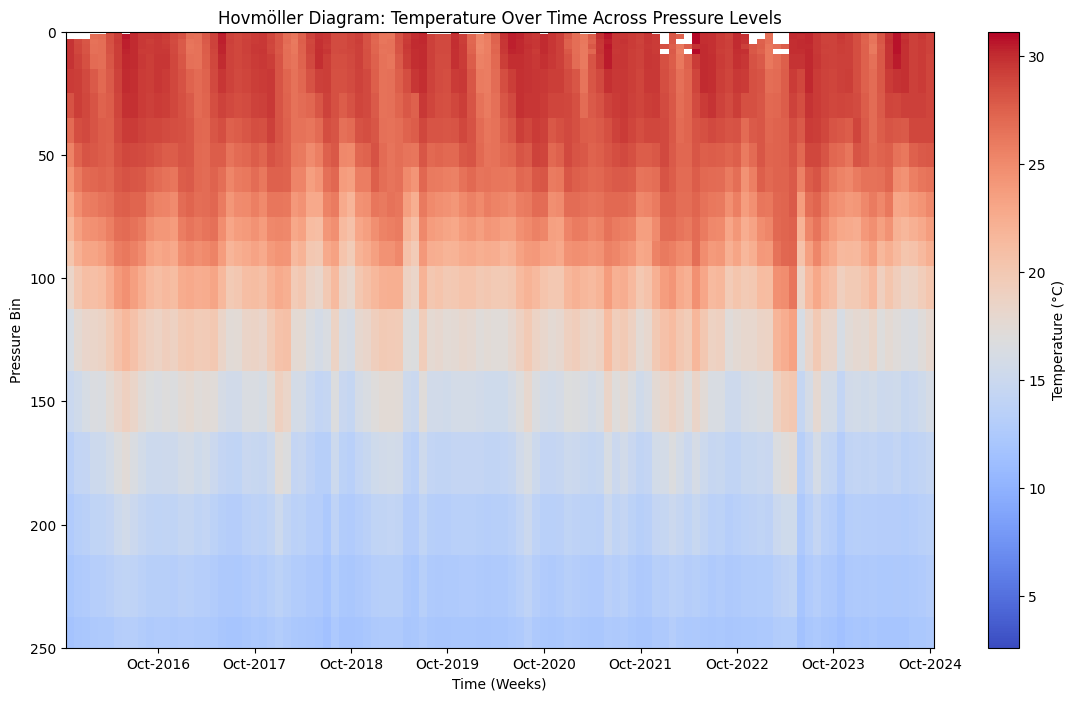

In [58]:
# Plot hovmoller diagram of weekly averaged temperature over the pressure bins
# Pivot the data to have TIME on the columns and PRES_BIN on the rows
hovmoller_data = resampled_data.pivot(index='PRES_BIN', columns='TIME', values='avg_temp')

hovmoller_data.columns = pd.to_datetime(hovmoller_data.columns)

# Plot the Hovmöller diagram with plt.pcolormesh
plt.figure(figsize=(14, 8))
plt.pcolormesh(hovmoller_data.columns, hovmoller_data.index, hovmoller_data.values, shading='auto', cmap='coolwarm')

# Customizing the plot
plt.colorbar(label='Temperature (°C)')
plt.gca().invert_yaxis()  # Invert y-axis to have surface at the top
plt.xlabel('Time (Weeks)')
plt.ylabel('Pressure Bin')
plt.title('Hovmöller Diagram: Temperature Over Time Across Pressure Levels')

# Format x-axis ticks to show only month-year
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=12))  # Show every month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))  # Format as 'Mon-Year'
plt.ylim(250,0)

# Display the plot
plt.show()

In [ ]:
# THIS SECTION IS WORK IN PROGRESS, WON't RUN as is

# #Bin data by season
# fall = df.loc[df['PRES']<1 & df['TIME'].between('2023-09-01','2024-01-01')]
# winter = df.loc[df['PRES']<1 & df['TIME'].between('2023-01-01','2024-04-01')]

# # Create a figure and axes
# fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': cartopy.crs.PlateCarree()})

# # Add features
# ax.add_feature(cartopy.feature.LAND)
# ax.add_feature(cartopy.feature.OCEAN)
# ax.add_feature(cartopy.feature.COASTLINE)
# ax.add_feature(cartopy.feature.BORDERS)

# # Plot your data
# scatter = ax.scatter(fall['LONGITUDE'],fall['LATITUDE'], transform=cartopy.crs.PlateCarree(), marker='o', c=fall['TEMP'], s=50)
# plt.colorbar(scatter)
# plt.xlim(80,95)
# plt.ylim(0,20)
# plt.xlabel('Longitude')
# plt.ylabel('Latitude')
# plt.title('Surface (pres<1dbar) temperatures in the fall')
# plt.show()